This notebook reproduces the tables and figures from the paper that describe our results in hallucination detection. 

# Reproduce numbers and images for hallucination detection

### Dependencies

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib

In [4]:
detection_data = pd.read_csv('../computed_data/detection_metrics.tsv', sep='\t')
gt = pd.read_csv('../annotated_data/guerreiro2022_corpus_w_annotations.csv')

In [5]:
full_metrics_list = detection_data.columns[14:]

In [6]:
gt['any_mistake'] = 1 - gt.correctness
gt['any_detached'] = gt[['strong-unsupport', 'full-unsupport']].max(1)
gt['repeat_or_detached'] = gt[['repetitions', 'strong-unsupport', 'full-unsupport']].max(1)
gt['other_errors'] = gt['any_mistake']-gt['named-entities']-gt['omission']-gt['repeat_or_detached']

In [7]:
error_rank = ['full-unsupport', 'strong-unsupport', 'repetitions', 'omission','named-entities']
error_classes = error_rank + ['other_error', 'correct']

def get_most_important_error(row):
    for e in error_rank:
        if row[e]:
            return e
    if row['correctness']:
        return error_classes[-1]
    else:
        return error_classes[-2]
    
gt['error_class'] = gt.apply(get_most_important_error, axis=1)

In [8]:
target_columns = ['any_mistake', 'repeat_or_detached', 'any_detached', 'full-unsupport']

###   Table 1: detection accuracies

In [9]:
selected_names = {
    'ref_chrfpp_neg': "ChrF", 
    'mt_log_loss_avg': "Seq-Logprob",
    'comet_qa_neg': "COMET-QE",
    'comet_ref_neg': "COMET",
    'laser_sim': "H-LASER",
    'labse_sim': "H-LaBSE",
    'nli_bf_joeddav/xlm-roberta-large-xnli': "H-XNLI",
    'alti_t_avg_sc': "ALTI",
}
selected = list(selected_names.keys())
#new_targets = ['Err', 'Hall', 'Part', 'Full']
ref_baselines = {'ref_chrfpp_neg', 'comet_ref_neg'}
baselines = {'ref_chrfpp_neg', 'mt_log_loss_avg', 'comet_qa_neg', 'comet_ref_neg'}
internals = {'mt_log_loss_avg', 'alti_t_avg_sc'}

def metric_type(text):
    if text in ref_baselines:
        return 'oracle'
    if text in internals:
        return 'internal'
    return 'external'

In [10]:
def get_precision_at_recall(targets, scores, target_recall=0.8):
    # the higher are the scores, the higher should be that targets==1
    threshold = scores[targets==1].quantile(1-target_recall)
    #print(threshold, targets[scores>=threshold].mean())
    #print(targets.groupby(scores>=threshold).value_counts())
    return targets[scores>=threshold].mean()

In [11]:
aucs = pd.DataFrame({
    target: {pred: roc_auc_score(gt[target], detection_data[pred]) for pred in full_metrics_list} 
    for target in target_columns
})

In [12]:
target_columns = ['repeat_or_detached']

tmp = pd.concat([
    aucs.loc[selected, target_columns], 
    pd.DataFrame({
        target: {pred: get_precision_at_recall(gt[target], detection_data[pred], 0.9) for pred in selected} 
        for target in target_columns
    })
], axis=1) * 100
tmp.columns = ['ROC AUC', 'P@R90%']
tmp.sort_values('ROC AUC', inplace=True, ascending=False)

tmp.insert(0, '', tmp.index.to_series().apply(metric_type))
tmp.index = [selected_names[c] for c in tmp.index]
#tmp.loc['Random baseline', :] = ['baseline', 0.5, 0.5, 0.5, 0.5]
#print(tmp.style.format(precision=2).to_latex())
print('Any hallucination vs other error or no pathology')
tmp.style.background_gradient().format(precision=2)

Any hallucination vs other error or no pathology


,,ROC AUC,P@R90%
H-LaBSE,external,91.72,25.87
H-XNLI,external,90.92,24.07
ALTI,internal,84.92,12.49
COMET,oracle,83.42,19.15
Seq-Logprob,internal,82.98,13.90
H-LASER,external,79.35,14.38
ChrF,oracle,75.43,14.44
COMET-QE,external,70.17,14.21


In [13]:
target_columns = ['full-unsupport']

tmp = pd.concat([
    aucs.loc[selected, target_columns], 
    pd.DataFrame({
        target: {pred: get_precision_at_recall(gt[target], detection_data[pred], 0.9) for pred in selected} 
        for target in target_columns
    })
], axis=1) * 100
tmp.columns = ['ROC AUC', 'P@R90%']
tmp.sort_values('ROC AUC', inplace=True, ascending=False)
tmp.insert(0, '', tmp.index.to_series().apply(metric_type))
tmp.index = [selected_names[c] for c in tmp.index]
#tmp.loc['Random baseline', :] = ['baseline', 0.5, 0.5, 0.5, 0.5]
#print(tmp.style.format(precision=2).to_latex())
tmp.style.background_gradient().format(precision=2)

,,ROC AUC,P@R90%
H-XNLI,external,98.67,60.42
ALTI,internal,98.66,67.44
H-LaBSE,external,98.47,70.30
Seq-Logprob,internal,93.48,31.02
H-LASER,external,91.22,20.75
ChrF,oracle,89.55,16.55
COMET,oracle,87.71,12.55
COMET-QE,external,66.10,6.04


###  Figure 2: KDE

# TODO: figure out, what distributions we realy want to plot

In [14]:
colors = {
    'correct': 'gray',
    'error': 'orange',
    'hallucination': 'red',
    'full-unsupport': 'red',
    'strong-unsupport': 'orange',
}

In [15]:
gt.error_class.value_counts()

correct             2048
other_error          836
omission             174
strong-unsupport     164
full-unsupport       129
named-entities        34
repetitions           30
Name: error_class, dtype: int64

In [16]:
def aggregate_error(e):
    if e in {'full-unsupport', 'strong-unsupport', 'repetitions'}:
        return 'hallucination'
    if e == 'correct':
        return 'correct'
    return 'error'
    
error_class_agg = gt.error_class.apply(aggregate_error)

In [17]:
negated = [
    'ref_chrfpp_neg', 'comet_qa_neg', 'comet_ref_neg', 'laser_sim', 'labse_sim', 
    'nli_bf_joeddav/xlm-roberta-large-xnli', 'alti_t_avg_sc', 'mt_log_loss_avg',
]

In [18]:
selected2 = [
    'mt_log_loss_avg',
    'comet_qa_neg',
    'comet_ref_neg',
    'ref_chrfpp_neg',
    'alti_t_avg_sc',
    'laser_sim',
    'labse_sim',
    'nli_bf_joeddav/xlm-roberta-large-xnli',
]

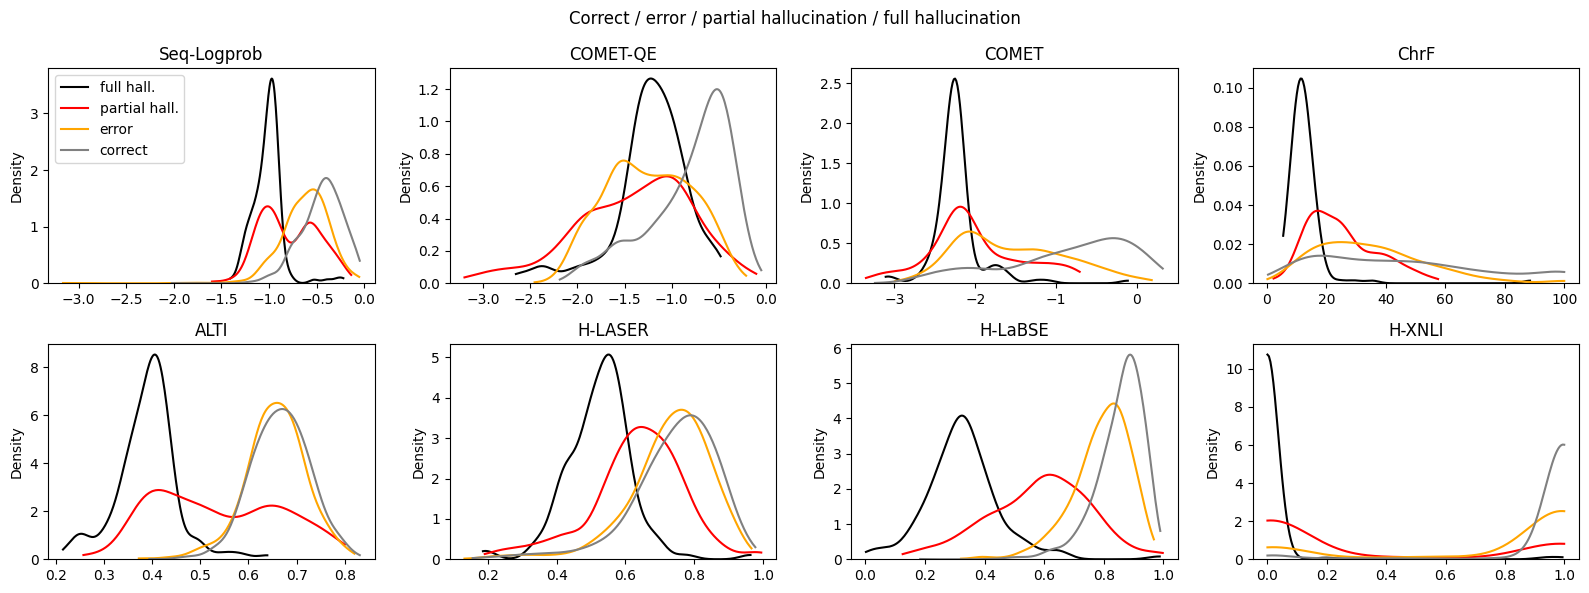

In [27]:
cut, bw = 0, 0.3
plt.figure(figsize=(16, 6))
for i, metric in enumerate(selected2):
    plt.subplot(2, 4, i+1)
    xx = detection_data[metric]
    if metric in negated:
        xx = -xx
    sns.kdeplot(xx[gt.error_class=='full-unsupport'].values, bw_method=bw, cut=cut, color='black')
    sns.kdeplot(xx[gt.error_class=='strong-unsupport'].values, bw_method=bw, cut=cut, color='red')
    sns.kdeplot(xx[error_class_agg=='error'].values, bw_method=bw, cut=cut, color='orange')
    sns.kdeplot(xx[gt.error_class=='correct'].values, bw_method=bw, cut=cut, color='grey')
    plt.title(selected_names[metric])
    if i == 0:
        plt.legend(['full hall.', 'partial hall.', 'error', 'correct'])
    
plt.suptitle('Correct / error / partial hallucination / full hallucination');
plt.tight_layout();

### Figure 3: proportions for selection

In [20]:
cmap = cm.get_cmap('Spectral', 20)    # PiYG
colors__ = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

cmap2 = cm.get_cmap('PiYG', 20)    # PiYG
colors2__ = [matplotlib.colors.rgb2hex(cmap2(i)[:3]) for i in range(cmap2.N)]


colors2 = {
          'Seq-Logprob': 'gray',
          'ALTI': colors2__[-5],
          'H-LASER': 'orange',
          'H-LaBSE': 'red',
          'H-XNLI': colors2__[0],
         }

linestyles2 = {'Seq-Logprob': 'dashed',
          'ALTI': 'solid',
          'H-LASER': 'solid',
          'H-LaBSE': 'solid',
          'H-XNLI': 'solid',
         }

linewidths2 = {'Seq-Logprob': 3,
          'ALTI': 5,
          'H-LASER': 3,
          'H-LaBSE': 3,
          'H-XNLI': 3,
         }

In [21]:
def radar(data):
    n = data.shape[0] + 1
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=n)
    plt.subplot(polar=True)
    for col in data.columns:
        dd = data[col].tolist()
        dd.append(dd[0])
        plt.plot(label_loc, dd, label=col, linewidth=linewidths2[col], color=colors2[col], linestyle=linestyles2[col])
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=list(data.index) + [''])

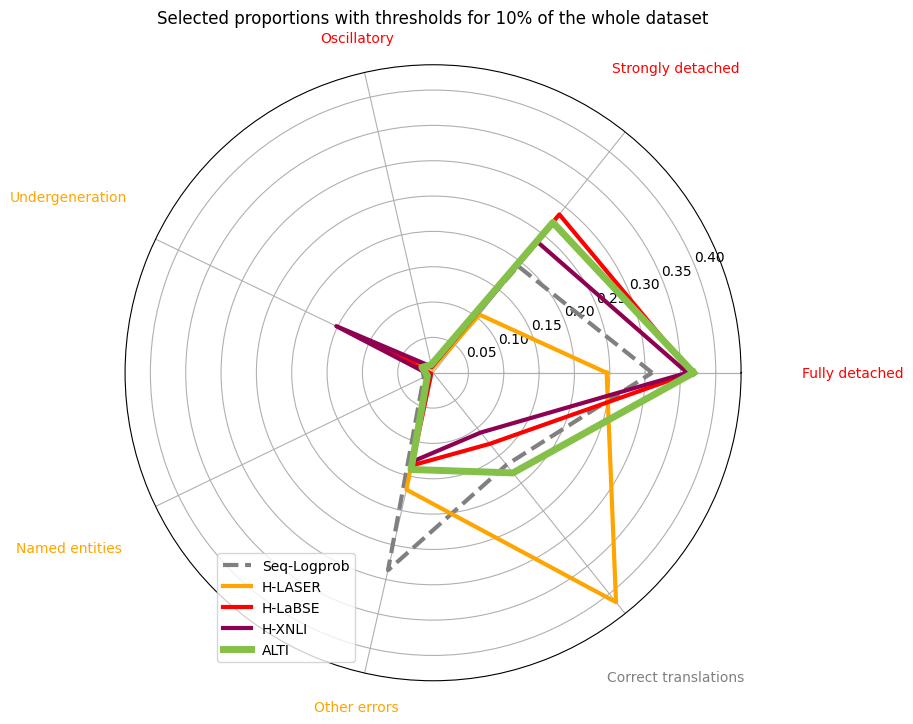

In [22]:
new_metrics = ['mt_log_loss_avg', 'laser_sim', 'labse_sim', 'nli_bf_joeddav/xlm-roberta-large-xnli', 'alti_t_avg_sc']

new_slices_names = dict(zip(
    error_classes,
    ['Fully detached', 'Strongly detached', 'Oscillatory', 'Undergeneration',  'Named entities', 'Other errors', 'Correct translations',]
))

df = pd.DataFrame({
    new_slices_names[data_slice]: {
        selected_names[metric]: (
            detection_data[metric][gt.error_class==data_slice] >= detection_data[metric].quantile(0.9)
        ).sum()
        for metric in new_metrics
    }
    for data_slice in error_classes
}).T
df = df / df.sum()


plt.figure(figsize=(8, 8))
radar(df)

plt.legend(loc=(0.15, 0.03))
plt.title('Selected proportions with thresholds for 10% of the whole dataset')

lines, labels = plt.thetagrids()
ys = [-0.3, -0.2, -0.05, -0.25, -0.25, -0.05, -0.2]
label_colors = ['red', 'red', 'red', 'orange', 'orange', 'orange', 'grey']
for label, y, color in zip(labels, ys, label_colors):
    label._y = y
    label._color = color

plt.show()


### Figure 4: recalls for selection

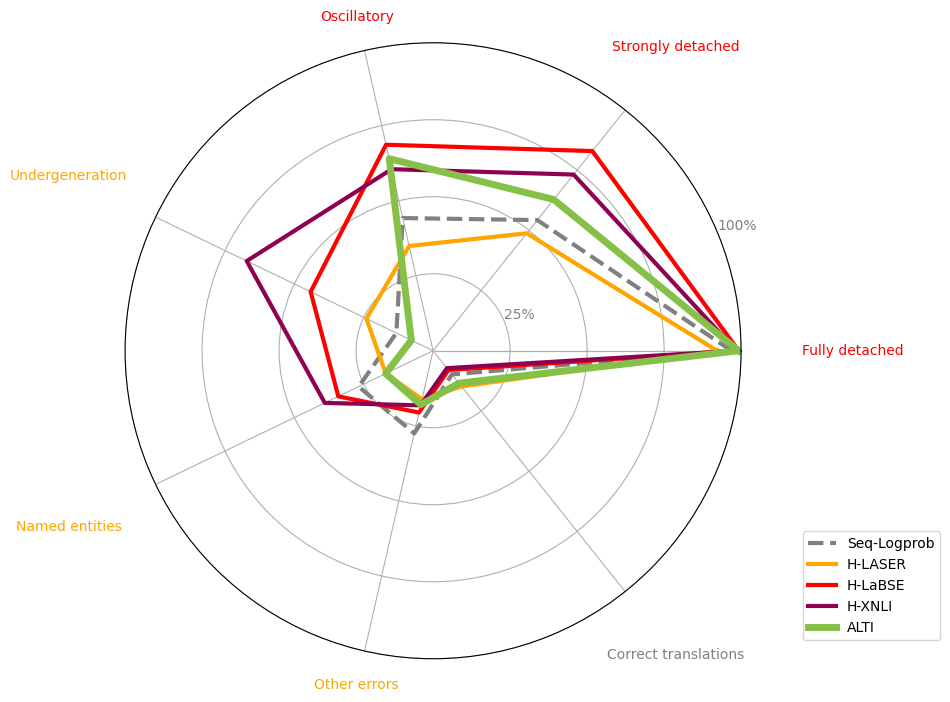

In [23]:
new_slices = [
    'full-unsupport', 'strong-unsupport', 'repetitions', 'omission',  'named-entities', 'other_errors', 
    'correctness',
]
new_slices_names = dict(zip(
    new_slices,
    ['Fully detached', 'Strongly detached', 'Oscillatory', 'Undergeneration',  'Named entities', 'Other errors', 'Correct translations',]
))
new_metrics = ['mt_log_loss_avg', 'laser_sim', 'labse_sim', 'nli_bf_joeddav/xlm-roberta-large-xnli', 'alti_t_avg_sc']

df = pd.DataFrame({
    new_slices_names[data_slice]: {
        selected_names[metric]: (
            detection_data[metric][gt[data_slice]==1] >= detection_data[metric].quantile(0.8)
        ).mean()
        for metric in new_metrics
    }
    for data_slice in new_slices
}).T

plt.figure(figsize=(8, 8))
radar(df)

plt.legend(loc=(1.1, 0.03))
# plt.title('Recalls for each pathology type')
plt.ylim(0, 1)


lines, labels = plt.thetagrids()
ys = [-0.3, -0.2, -0.05, -0.25, -0.25, -0.05, -0.2]
label_colors = ['red', 'red', 'red', 'orange', 'orange', 'orange', 'grey']
for label, y, color in zip(labels, ys, label_colors):
    label._y = y
    label._color = color


plt.yticks([0.25, 0.5, 0.75, 1], ['25%', '', '', '100%'], c='gray')

plt.show()
